### Outline
- Ford-Fulkerson algorithm
- A few remarks on toll in traffic applications
- Averaging dynamics

## Back to max-flow problems: Ford-Fulkerson algorithm

It is given a graph $G = (V, E)$ which represents a flow network, and two vertices source $s$ and sink $t$ in it. Every edge $(u,v)$ has a capacity $c(u,v)$. We want to find the maximum possible flow from $s$ to $t$ with the following constraints.

The desired flow $f$ is constructed iteratively starting from a zero-flow vector: at each round of the algorithm $f$ is updated in such a way that the capacity and balance constraints are not violated.

To do this, at each round, given the current flow vector $f$, we define the **residual network** $G_{f}(V,E_{f})$ to be the network with capacity $c_{f}(u,v)=c(u,v)-f(u,v)$. A search on the residual graph $G_f$ is performed to find an **augmenting path** (i.e., a path on the residual network with positive capacity on every edge of the path). If an augmenting path is found, this means that the current flow $f$ on that path can be increased.

### The algorithm 
**Inputs**: a graph $G=(V,E)$, a vector of flow capacities $c = (c(u,v))_{(u,v) \in E}$, a source node $s$, and a sink node $t$

**Output**: a flow $f = (f(u,v))_{(u,v) \in E}$ from $s$ to $t$ of maximum throughput

1. $f(u,v)\leftarrow 0$ for all edges $(u,v)$
2. While there is a path $p$ from $s$ to $t$ in $G_{f}$, such that $c_{f}(u,v)=c(u,v)-f(u,v)>0$ for all edges $(u,v)\in p$:
 1. Find $c_{f}(p)=\min\{c_{f}(u,v):(u,v)\in p\}$
 2. For each edge $(u,v)\in p:$
      1. $f(u,v)\leftarrow f(u,v)+c_{f}(p)$ (Increase the flow along the path)
      2. $f(v,u)\leftarrow f(v,u)-c_{f}(p)$ (Impose the symmetry of the flow)

Ford-Fulkerson Algorithm does not specify how to select paths, this is arbitrary.

### Example: iterative Ford-Fulkerson by hand

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])

pos = {0: (40, 20), 1: (60, 35), 2: (60, 5), 3: (80, 20)}

labels = ['0/1000','0/1000','0/1','0/1000','0/1000']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True)

We choose the augmenting path 0-1-3, with residual capacity equal to 1000.

In [ ]:
labels = ['1000/1000','0/1000','0/1','1000/1000','0/1000']

colors = ['red','black','black','red','black']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

There is now only an augmenting path, which is 0-2-3, with residual capacity equal to 1000

In [ ]:
labels = ['1000/1000','1000/1000','0/1','1000/1000','1000/1000']

colors = ['black','red','black','black','red']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels = True, edge_color = colors)

### Edmonds-Karp Algorithm
The Edmonds–Karp algorithm is an implementation of Ford–Fulkerson where the search order to find augmenting paths is defined. A shortest path that has available capacity is found by a breadth-first search.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import collections

# This class represents a directed graph using adjacency matrix representation
class Graph:
    # __init__ is a reseved method in python classes.
    # In object oriented terminology, it is the constructor of the class.
    # We define a new class 'graph' instead of using the NetworkX package.
    def __init__(self, graph): 
        # the Graph object represents the flow network and the graph
        # attribute will be updated by the Edmonds-Karp Algorithm to 
        # represent the residual graph.
        # Entry [u][v] of graph array stores the capacity of link (u,v).
        self.graph = graph  
        # Number of nodes:
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        """Returns true if there is a path from source 's' to sink 't' in the
        residual graph. Also fills parent[] to store the path """
        # Mark all the vertices as not visited
        visited = [False] * (self.ROW)

        # Create a double-ended queue
        queue = collections.deque()

        # Mark the source node as visited and enqueue it
        # When visited, nodes are appended "to the right end" of the queue
        # We start by visiting the source
        queue.append(s)
        visited[s] = True

        # Standard BFS loop
        while queue: # while there are still elements in the queue
            # Nodes are extracted from "the left end" of the queue
            u = queue.popleft()

            # Get all adjacent vertices of the dequeued vertex u
            # If an adjacent vertex has not been visited, then mark 
            # it as visited and enqueue it.
            
            # Enumerate() method adds a counter to an iterable
            # to keep a count of iterations. We cycle over row
            # u of graph array: ind is the index of the node,
            # val is >0 if node ind is adjacent to u, i.e. if 
            # there is residual capacity on the link (u,ind),
            # it is 0 otherwise.
            for ind, val in enumerate(self.graph[u]): 
                if (visited[ind] == False) and (val > 0):
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        # If sink is reached by BFS starting from source, then return
        # true, else return false
        return visited[t]

    # Returns the maximum flow from s to t in the given graph
    def edmonds_karp(self, source, sink):
        # parent array is filled by bfs() and it is used 
        # to compute augmenting paths.
        # It is initialized with the sentinel value -1
        parent = [-1] * (self.ROW)

        # Both max flow value and max flow vector are 
        # initialized to 0
        max_flow = 0  
        # initialize matrix of zeros with size ROW x ROW
        flow = np.array([[0] * (self.ROW)] * (self.ROW))

        # Augment the flow while there is a path from source to sink
        # in the residual graph
        while self.bfs(source, sink, parent): # the algorithm stops when there are no augmenting paths from s to t
            # now parent stores the augmenting path found by bfs

            # Find the minimum residual capacity of the edges along the
            # origin-destination path found by BFS.
            res_capacity = float("Inf")
            # start from the endpoint of the path
            n = sink
            # travel the path backwards until you reach the source
            # and update the minimal residual capacity of links
            while n != source:
                res_capacity = min(res_capacity, self.graph[parent[n]][n])
                n = parent[n] 

            # Add the residual capacity to the maximal throughput
            max_flow += res_capacity

            # Update the flow vector by adding the residual capacity
            # of the augmenting path to each edge in the path (to preserve
            # symmetry, subtract it to each reverse edge).
            # Compute the new residual network by updating
            # the residual capacities of the edges and reverse edges
            # along the augmenting path.
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += res_capacity
                flow[v][u] -= res_capacity
                self.graph[u][v] -= res_capacity
                self.graph[v][u] += res_capacity
                v = parent[v]  
            
        return max_flow, flow

In [ ]:
W = np.array([[0,1000,1000,0],[0,0,1,1000],[0,0,0,1000],[0,0,0,0]])
G = Graph(W)

max_flow, flow = Graph.edmonds_karp(G,0,3)

print("The maximum flow:", max_flow, "\n")
print("The flow distribution: \n", flow)

Let us explore the steps of the algorithm by adding some print in the code.

In [ ]:
class Graph_print:
    # __init__ is a reseved method in python classes.
    # In object oriented terminology, it is the constructor of the class.
    # We define a new class 'graph' instead of using the NetworkX package.
    def __init__(self, graph): 
        # the Graph object represents the flow network and the graph
        # attribute will be updated by the Edmonds-Karp Algorithm to 
        # represent the residual graph.
        # Entry [u][v] of graph array stores the capacity of link (u,v).
        self.graph = graph  
        # Number of nodes:
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        """Returns true if there is a path from source 's' to sink 't' in the
        residual graph. Also fills parent[] to store the path """
        # Mark all the vertices as not visited
        visited = [False] * (self.ROW)

        # Create a double-ended queue for BFS
        queue = collections.deque()

        # Mark the source node as visited and enqueue it
        # When visited, nodes are appended "to the right end" of the queue.
        queue.append(s)
        visited[s] = True

        # Standard BFS loop
        while queue: # while there are still elements in the queue
            # Nodes are extracted from "the left end" of the queue
            print("Queue:", queue, "\n")
            u = queue.popleft()
            print("Extracted node:", u, "\n")

            # Get all adjacent vertices of the dequeued vertex u
            # If an adjacent vertex has not been visited, then mark 
            # it as visited and enqueue it.
            
            # Enumerate() method adds a counter to an iterable
            # to keep a count of iterations. We cycle over row
            # u of graph array: ind is the index of the node,
            # val is >0 if node ind is adjacent to u, i.e. if 
            # there is residual capacity on the link (u,ind),
            # it is 0 otherwise.
            for ind, val in enumerate(self.graph[u]): 
                if (visited[ind] == False) and (val > 0):
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u
            
            print("Parents", parent, "\n")
            print("Visited", visited, "\n \n \n")

        # If sink is reached by BFS starting from source, then return
        # true, else return false
        return visited[t]

    # Returns the maximum flow from s to t in the given graph
    def edmonds_karp(self, source, sink):
        n_iter = 1
        print("iteration of bfs number:", n_iter, "\n")
        # parent array is filled by bfs() and it is used 
        # to compute augmenting paths.
        # It is initialized with the sentinel value -1
        # If parent[j] == -1, node 'j' has not been visited yet
        parent = [-1] * (self.ROW)

        # Both max flow value and max flow vector are 
        # initialized to 0
        max_flow = 0  
        # initialize matrix of zeros with size ROW x ROW
        flow = np.array([[0] * (self.ROW)] * (self.ROW))

        # Augment the flow while there is a path from source to sink
        # in the residual graph
        while self.bfs(source, sink, parent): # the algorithm stops when there are no augmenting paths from s to t
            # now parent stores the augmenting path found by bfs

            # Find the minimum residual capacity of the edges along the
            # origin-destination path found by BFS.
            res_capacity = float("Inf")
            # start from the endpoint of the path
            n = sink
            # travel the path backwards until you reach the source
            # and update the minimal residual capacity of links
            while n != source:
                res_capacity = min(res_capacity, self.graph[parent[n]][n])
                n = parent[n] 

            # Add the residual capacity to the maximal throughput
            max_flow += res_capacity

            # Update the flow vector by adding the residual capacity
            # of the augmenting path to each edge in the path (to preserve
            # symmetry, subtract it to each reverse edge).
            # Compute the new residual network by updating
            # the residual capacities of the edges and reverse edges
            # along the augmenting path.
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += res_capacity
                flow[v][u] -= res_capacity
                self.graph[u][v] -= res_capacity
                self.graph[v][u] += res_capacity
                v = parent[v]  
            n_iter += 1
            print("iteration of bfs number:", n_iter, "\n")
            
        return max_flow, flow

In [ ]:
W = np.array([[0,1000,1000,0],[0,0,1,1000],[0,0,0,1000],[0,0,0,0]])
G = Graph_print(W)

max_flow, flow = Graph_print.edmonds_karp(G,0,3)

Networkx implements the Edmonds-Karp algorithm. 

The `networkx.algorithms.flow.edmonds_karp` function returns the residual network resulting after computing the maximum flow.

Networkx also provides the functions `networkx.algorithms.flow.maximum_flow` and `networkx.algorithms.flow.minimum_cut` which compute the maximun throughput and  the value and the node partition of a minimum cut, respectively.

## Back to traffic application: system optimum vs Wardrop equilibria

We have seen an example on this network, with throughput 1.

![figure](pigou.png)

<span style="background-color: #3333FF">Optimal flow is the feasible flow $f^*$ that minimizes $\sum_e \psi_e(f_e)$, (typically, $\psi_e(f_e) = f_e d_e(f_e)$)</span>

<span style="background-color: #3333FF">Wardrop equilibrium is a flow such that no users have incentive in modifying their path.</span>

Optimal flow (with respect to standard cost functions) is $f^* = (1/2, 1/2)$

Wardrop equilibrium is $f^{(0)} = (1,0)$

In this example, the optimal cost is $\sum_e f_e^* d_e(f_e^*) = 0.75$. Notice that $d_1(f_1^*) = 1/2, d_2(f_2^*) = 1$

The cost at Wardrop is $\sum_e f_e^{(0)} d_e(f_e^{(0)}) = 1$. Notice that $d_1(f_1^*) = d_2(f_2^*) = 1$

### <span style="background-color: #00FF00">How to add tolls: marginal tolls</span>
We add tolls $\omega \in \mathrm{R}^E_+$, such that users choose the path based on delay functions $d_e^{(\omega_e)}(f_e) = d_e(f_e) + \omega_e$. <span style="background-color: #FF1493">We would like to find optimal tolls $\omega^*$ such that the Wardrop equilibrium with tolls is equal to the social optimum flow, i.e., $f^* = f^{(\omega^*)}$, where</span>

\begin{equation}
\begin{aligned}
	f^{*} \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& & \sum_{e \in E} \psi_e(f_e).
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
	f^{(\omega^*)} \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& & \sum_{e \in E} \int_{0}^{f_e} d_e^{(\omega^*_e)} (s) ds.
\end{aligned}
\end{equation}

**Theorem**: <span style="background-color: #FF1493">An optimal toll configuration is $\omega^*_e = \psi_e'(f_e^*) - d_e(f_e^*)$ for all links $e$.</span>

**Remark**: <span style="background-color: #FF1493">Those tolls are called marginal pricing tolls.</span> <span style="background-color: #FF1493">However, optimal tolls do not have to be unique, there might exist other optimal tolls.</span> <span style="background-color: #FF1493">For standard cost function $\psi_e(f_e) = f_e d_e(f_e)$, marginal pricing tolls read $\omega_e^* = f_e^* d_e'(f_e^*)$.</span>

# <mark>Linear averaging dynamics</mark>
In the first part of the lab we study linear averaging dynamics on graphs.

Let $G=(V,E,W)$ be a weighted graph, and $x(t) \in \mathrm{R}^{V}$ denote the state of the nodes of the graph.

The dynamics of $x(t)$ reads

$$
x(t+1) = Px(t),
$$

where $P$ is the normalized adjacency matrix.
Among the applications, the most popular is opinion dynamics, where $x_i$ indicates the opinion of node $i$. This dynamics is known as French - De Groot.

Note that we assume by convention that the opinion of node $i$ is influenced by the opinion of node $j$ if $P_{ij}>0$, i.e., the link $(i,j)$ has to be interpreted as $i$ watching $j$ and updating her opinion based on opinion of $j$.

**Observation**: observe that $\mathbf{1}$ is an equilibrium distribution, since $\mathbf{1} = P \mathbf{1}$ ($P$ is row-stochastic by construction), i.e., consensus distributions are equilibria of the dynamics.

**Question**: what are the conditions under which the dynamics converges to consensus?

**Theorem**: assume that
- its condensation graph has 1 sink;
- the sink component of the graph is aperiodic;

Then,

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

i.e., the agents get to consensus.

## <span style="background-color: #00FF00">Why aperiodicity matters: example</span>

Number of nodes: 4


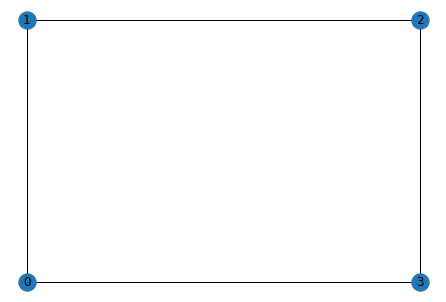

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0)])
n_nodes = len(G)
print("Number of nodes:", n_nodes)

# labels of nodes are couples: (column,row)
pos = {0:[0,0], 1:[0,2], 2:[2,2], 3:[2,0]}
nx.draw(G, pos, with_labels=True)

Note that the graph is periodic because of every cycle has even length (the graph is bipartite and undirected, thus its period is 2)

In [3]:
# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [4]:
# Construct a dictionary that maps the label of nodes  
# (from (0,0) to (2,1)) to their index (from 0 to n_nodes-1)
indices = dict()
for i in range(n_nodes):
    indices[list(G.nodes)[i]] = i
print(indices)

{0: 0, 1: 1, 2: 2, 3: 3}


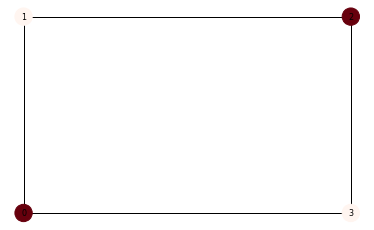

In [5]:
# Assign initial opinion to nodes and run the dynamics
x = np.array([1,0,1,0])

nodecolor=x

# plot centrality at iteration 0
plt.figure(1, figsize=(5,3))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         nodelist=list(G.nodes()), 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=nodecolor,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds,
         with_labels=True) 

Nodes with opinion 1 are red, nodes with opinion 0 are white.

After one iteration...

x(1): [0. 1. 0. 1.]


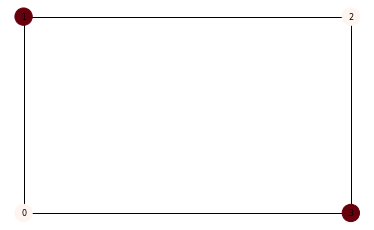

In [6]:
x = P @ x

nodecolor=x

plt.figure(1, figsize=(5,3))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         nodelist=list(G.nodes()), 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=nodecolor,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds,
         with_labels=True) 

print("x(1):", x)

What do you expect after 5 iterations from the initial condition?

x(5): [0. 1. 0. 1.]


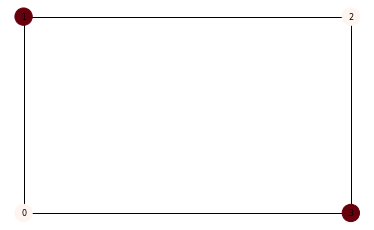

In [7]:
x = P @ P @ P @ P @ x

nodecolor=x

plt.figure(1, figsize=(5,3))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         nodelist=list(G.nodes()), 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=nodecolor,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds,
         with_labels=True) 

print("x(5):", x)

Periodicity of the graph does not allow a proper mixing of the opinions!

Let us add a link to make the graph aperiodic.

Number of nodes: 4


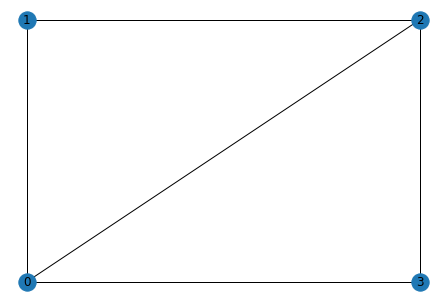

In [8]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0)])
G.add_edge(0,2)
n_nodes = len(G)
print("Number of nodes:", n_nodes)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# labels of nodes are couples: (column,row)
nx.draw(G, pos, with_labels=True)

Let us run again the dynamics with same initial conditions as before.

In [9]:
x = np.array([1,0,0,1])

x = P @ x
print("x(1):", x)

x = P @ x
print("x(2):", x)

x = P @ x
print("x(3):", x)

x = P @ x
print("x(4):", x)

x = P @ x
print("x(5):", x)

x = P @ P @ P @ P @ P @ x
print("x(10):", x)

x = P @ P @ P @ P @ P @ x
print("x(15):", x)

x = P @ P @ P @ P @ P @ x
print("x(20):", x)

x = P @ P @ P @ P @ P @ x
print("x(25):", x)

x = P @ P @ P @ P @ P @ x
print("x(30):", x)

x(1): [0.33333333 0.5        0.66666667 0.5       ]
x(2): [0.55555556 0.5        0.44444444 0.5       ]
x(3): [0.48148148 0.5        0.51851852 0.5       ]
x(4): [0.50617284 0.5        0.49382716 0.5       ]
x(5): [0.49794239 0.5        0.50205761 0.5       ]
x(10): [0.50000847 0.5        0.49999153 0.5       ]
x(15): [0.49999997 0.5        0.50000003 0.5       ]
x(20): [0.5 0.5 0.5 0.5]
x(25): [0.5 0.5 0.5 0.5]
x(30): [0.5 0.5 0.5 0.5]


The dynamics reachs consensus.

### Two questions
- How fast the consensus is achieved?
- What is the consensus value?

We will answer to these questions later on.

## <span style="background-color: #00FF00">Why 1 sink in the condensation graph: example</span>

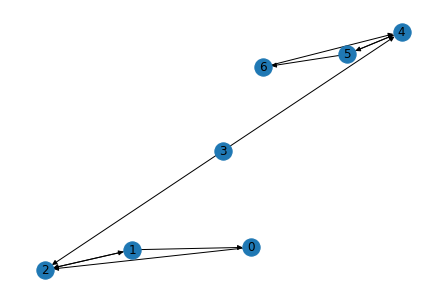

In [10]:
G = nx.DiGraph()
G.add_edges_from([(1,2),(2,1),(1,0),(0,2),(3,2),(3,4),(4,5),(5,4),(6,4),(5,6)])

# labels of nodes are couples: (column,row)
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True)

How many sink components does this graph have?

Let us compute the condensation graph.

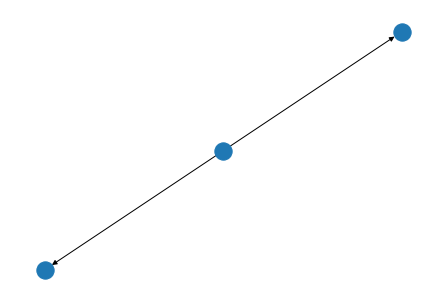

In [11]:
CG = nx.algorithms.components.condensation(G)

nx.draw(CG)

The condensation graph has 2 sinks. Thus, the sufficient conditions under which the dynamics converges to consensus does not hold.

Let us figure out why by an example.

In [12]:
# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# define initial condition
x = [1, 1, 0, 1, 1, 0, 0]

for n in range(100):
    x = P @ x
print("x(100):", x)

x(100): [0.8 0.8 0.8 0.6 0.4 0.4 0.4]


The dynamics does not reach consensus.

**Question**: can you intuitively understand why?

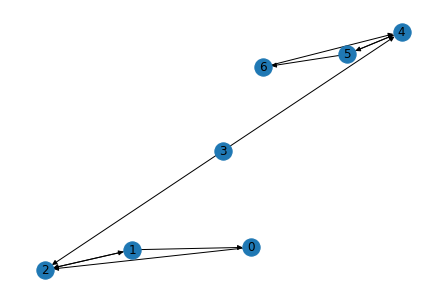

In [13]:
nx.draw(G, pos, with_labels=True)

Let us now add a link in such a way that the condensation graph has now a single sink.

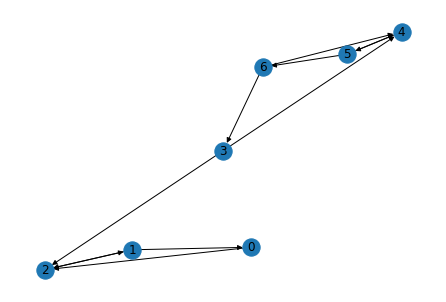

In [14]:
G.add_edge(6,3)
nx.draw(G, pos, with_labels=True)

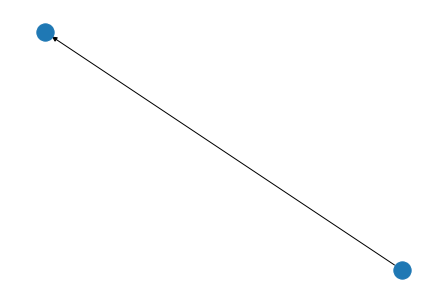

In [15]:
CG = nx.algorithms.components.condensation(G)
nx.draw(CG)

Let us now run the dynamics.

In [16]:
# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# define initial condition
x = [1, 1, 0, 1, 1, 0, 0]

for n in range(99):
    x = P @ x
print("x(100):", x, "\n")

for n in range(199):
    x = P @ x
print("x(200):", x, "\n")

for n in range(999):
    x = P @ x
print("x(1000):", x)

x(100): [0.8        0.8        0.8        0.79879255 0.79770667 0.79782211
 0.79815683] 

x(200): [0.8        0.8        0.8        0.79999996 0.79999992 0.79999993
 0.79999994] 

x(1000): [0.8 0.8 0.8 0.8 0.8 0.8 0.8]


We now reach consensus!!

## <span style="background-color: #00FF00">Consensus value</span>

How is the consensus value computed?

Let $\pi$ denote the normalized left dominant eigenvector of $P$, i.e., the normalized $\pi$ such that $P' \pi = \pi$ (which is unique because the graph has one sink only).
We use the fact that

$$
\pi' x(t) = \pi' P x(t-1) = \pi' x(t-1),
$$

thus $\pi' x(t)$ is constant along the dynamics. Thus,

$$
\pi' x(0) = \pi' \lim_{t \to + \infty} x(t) = \alpha \pi' \mathbf{1} = \alpha.
$$

Thie computation above says that the consensus value $\alpha$ is the weighted average of the initial conditions of the nodes, where the weights are given by the (unique) invariant distribution $\pi$.

Recall that $\pi$ solving $\pi = P' \pi$ is also the invariant distribution centrality, thus the more a node is central the more its initial opinion affects the consensus value.

Let us explore the form of $\pi$ for this example.

pi 0 = [ 0.4  0.4  0.2 -0.  -0.  -0.  -0. ]


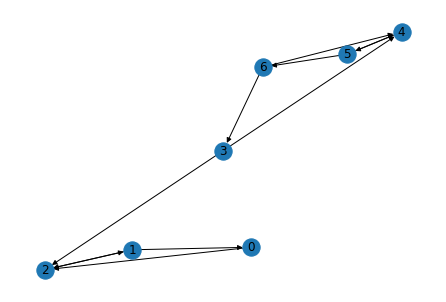

In [17]:
w,v = np.linalg.eig(P.T)

# selects the eigenvalue 1 (i.e., dominant eigenvalue) and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
    pi = pi/np.sum(pi) # normalization
    print("pi", index, "=", pi)
    
nx.draw(G,pos,with_labels=True)

<span style="background-color: #FAEBD7">The invariant distribution centrality is 0 for all the nodes that do not belong to the sink of the condensantion graph!</span>

<span style="background-color: #FAEBD7">This implies that the initial opinion of the nodes not belonging to the sink are negligible for the consensus value.</span>

<span style="background-color: #FAEBD7">The intuition for this is that the nodes 0, 1 and 2 do not care of the other nodes, because are not out-connected to any other node out of the component, and they reach consensus because the induced subgraph on 0,1,2 is aperiodic and strongly connected.
Thus, their evolution is not affected by other nodes. Conversely, the other nodes update their opinion based on 2 also, thus eventually they tend to agree to the opinion of node 2 (and thus 0 and 1 as well).</span>

Let us modify the initial condition of nodes 3,4,5,6 to observe that the consensus value is not affected by this modification.

In [18]:
# define initial condition
x = [1, 1, 0, 80, 25, 8, 12]

for n in range(99):
    x = P @ x
print("x(100):", x, "\n")

for n in range(200):
    x = P @ x
print("x(300):", x, "\n")

for n in range(1000):
    x = P @ x
print("x(1300):", x)

x(100): [0.8        0.8        0.8        0.87450582 0.94151047 0.93438691
 0.91373342] 

x(300): [0.8        0.8        0.8        0.80000243 0.80000462 0.80000439
 0.80000371] 

x(1300): [0.8 0.8 0.8 0.8 0.8 0.8 0.8]


## <span style="background-color: #00FF00">Speed of convergence</span>

Let us work now for undirected (the following argument holds only for undirected) connected graphs. If the graph is also aperiodic, the dynamics is guaranteed to converge to consensus.

<span style="background-color: #FAEBD7">Let $\lambda:=\max \{\lambda_2,|\lambda_n|\}$, where $\lambda_1 \ge \lambda_2 \ge \cdots \ge \lambda_n$ are the eigenvalues of $P$. Recall that $\lambda_n \ge -1$ by construction of $P$.</span>

<span style="background-color: #FAEBD7">It is known that the dynamics reaches consensus exponentially fast. In particular, the distance from consensus at time $t$ is in some sense proportional to $\lambda^t$ (this will be shown more formally in the theoretical lectures).</span>

<span style="background-color: #FAEBD7">Thus, if $\lambda$ is close to $1$, then the convergence is slow, whereas if $\lambda$ is small the convergence is faster.</span>

<span style="background-color: #FAEBD7">Note also that for periodic graphs, by Perron-Frobenius theorem have $\lambda_n = -1$ (thus $\lambda=1$), then the convergence to consensus is not achieved. This is coherent with the theory of consensus.</span>

**<span style="background-color: #FAEBD7">Remark</span>**: note that every periodic strongly connected graph can be made periodic by adding at least a selfloop in the graph. Indeed, if a selfloop $(i,i)$ is added, then the period of node $i$ is 1. Since all the nodes in the same connected component have same period, then all the nodes have period $1$ and the graph is aperiodic.

To avoid periodic graphs, sometimes it is useful to introduce the **lazy dynamics** obtained by replacing $P$ with 

$$
\frac{P+\mathbf{I}}{2}
$$

This is equivalent to adding selfloops to each node in the graph with weight equivalent to the degree of the node itself.

An interpretation for the lazy dynamics is that nodes have some inertia in the opinion. Instead of averaging over the opinions of the neighbors, they also take into account their opinion at the previous step. In fact,

$$
x_i(t+1) = \frac{x_i(t) + \sum_{j} P_{ij} x_j(t)}{2}.
$$

Let us go back to the initial periodic example, and show that the lazy dynamics converges.

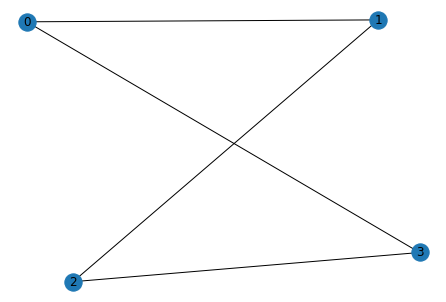

In [19]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3),(3,0)])

# labels of nodes are couples: (column,row)
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [20]:
P = P/2 + np.diag(np.ones(4))/2

x = np.array([1, 0, 1, 0])

for n in range(9):
    x = P @ x
print("x(10):", x)

x(10): [0.5 0.5 0.5 0.5]


### <span style="background-color: #00FF00">How fast is the convergence of lazy dynamics?</span>

Note that $\lambda_n(P_{lazy}) = 1/2 + \lambda_n(P)/2 \ge 1/2 + (-1/2) = 0$.

Thus, $\lambda = \lambda_2$. 

In the lazy dynamics, the speed convergence is governed by $\lambda_2$. Let us now define the relaxation time as

$$
\tau_{rel} = \frac{1}{1-\lambda_2}
$$

For undirected graphs, $\lambda_2$ may be related to the level of connectedness of the graph. In particular, if the graph is well connected, $\lambda_2$ is smaller and the convergence to consensus is faster.

We do not investigate the details on how to define "connectedness" of graphs in proper way here. However, we can verify by a simple example how connectedness of the graph influences the speed of convergence.

Let us consider a **cycle graph** with 1000 nodes.

For the cycle graph one can show that

$$
\lambda_2(P) = \cos \left(\frac{2\pi (n-1)}{n}\right).
$$

Thus,

$$
\lim_{n \to + \infty} \lambda(P_{lazy}) = \frac{1}{2} + \lim_{n \to + \infty} \frac{1}{2} \cos \frac{2\pi}{n} = 1-\frac{\pi}{n},
$$

and the relaxation time for the cycle is

$$
\tau_{rel} = \frac{n}{\pi}.
$$

This means that the convergence is achieved exponentially with a rate that scales linearly with $n$.

In [21]:
G = nx.cycle_graph(1000)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Construct lazy P
P = P = P/2 + np.diag(np.ones(1000))/2

# let us start with random initial conditions
x = np.random.rand(1000)

variance = np.var(x)
t=0

while (variance>0.001):
    x = P @ x
    t=t+1
    variance = np.var(x)

print('Number of iteration for convergence:', t)

Number of iteration for convergence: 1078


Let us consider the complete graph, which is the most connected graph by definition. For the complete graph,

$$
W=\mathbf{1}\mathbf{1}'-I.
$$

Since $\mathbf{1}\mathbf{1}'$ has equal columns, it has rank $1$. Thus $\mathbf{1}\mathbf{1}'$ has $n-1$ eigenvalues equal to $0$. The remaining eigenvalue can be found by using the fact that the sum of the eigenvalues is the trace of the matrix. Since $=\mathbf{1}\mathbf{1}'-I$, the spectrum of $W$ is

$$
\sigma_W = \{n-1,-1,\cdots,-1\}
$$

Since the complete graph is regular and every node has degree $n-1$, $P=W/(n-1)$
Thus, the spectrum of $P$ is

$$
\sigma_P = \{1,-\frac{1}{n-1},\cdots,-\frac{1}{n-1}\},
$$

and $P_{lazy}$ has spectrum

$$
\sigma_{P_{lazy}} = \{1,-\frac{1}{2(n-1)}+\frac{1}{2},\cdots,-\frac{1}{2(n-1)}+\frac{1}{2}\}
$$

This implies that $\lambda_2 = \frac{1}{2}-\frac{1}{2(n-1)} = \frac{n-2}{2(n-1)}$ and the relaxation time for large $n$ in the complete graph tends

$$
\lim_{n \to +\infty} \tau_{rel} = 2,
$$

i.e., even for infinite $n$ the relaxation time is finite.

In [22]:
G = nx.complete_graph(1000)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# Construct lazy P
P = P = P/2 + np.diag(np.ones(1000))/2

# let us start with random initial conditions
x = np.random.rand(1000)

variance = np.var(x)
n=0

while (variance>0.001):
    x = P @ x
    n=n+1
    variance = np.var(x)

print('Number of iteration for convergence:', n)

Number of iteration for convergence: 4


## <span style="background-color: #00FF00">Wisdom of crowds</span>
Consider a graph, and assume that state of each node represents a noisy estimate of the real state $\mu$, i.e.,

$$
x_i = \mu + y_i,
$$

with $E[y_i]=0$, and the variance $\sigma^2 (y_i) = \sigma^2$ for each $i$.

Assume that the graph is connected and aperiodic Eventually, the agents will reach consensus, i.e., $\lim_{t \to +\infty} x(t) = \alpha \mathbf{1}$. 

**Question**: what is the consensus value $\alpha$?

Notice that $\alpha = \pi' (\mu \mathbf{1} + y) = \mu + \pi'y$, then

$$
E[\alpha] = \mu + \pi' E[y] = \mu
$$

so the final estimate of the network is unbiased. Moreover,

$$
\quad \sigma_{\alpha}^2 = \sigma^2 \sum_{i} \pi_i^2 < \sigma^2,
$$

because $\sum_{i} \pi_i^2 <1$ unless the graph has a unique sink node. The interesting observation is that the estimate $\alpha$ has a smaller variance than $\sigma$, i.e., the crowd is able to reconstruct a more precise estimate of the real state than the single agents of the graph.

Let us verify this on a complete graph, where $\pi_i = 1/n$, thus $\sigma_\alpha^2 = \sigma^2/n$. 

In [23]:
G = nx.complete_graph(100)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# start with random initial states and run the dynamics 200 times
# store in alfa_err the consensus values at each run
alfa_err = np.zeros(200)

for i in range(200):
# rand returns random values in [0,1], thus \mu = 1/2
    x = np.random.rand(100)
    var = np.var(x)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))

print("Variance of the node states:", 1/12)
print("Variance of the consensus state:", np.mean(alfa_err), "\n")

Variance of the node states: 0.08333333333333333
Variance of the consensus state: 0.0009471303594215441 



As expected the variance of $\alpha$ is about $1/100$ of the original variance.

Note that $\sum_{i} \pi_i^2$ tends to 1 if one node has almost all the centrality, and is minimal when the nodes have the same centrality (as in the complete graph, or in the cycle graph). This implies that if a graph is more 'democratic', then the consensus algorithm leads to better estimates of the true state. If a few nodes have all the centralities, the consensus value is less reliable.

Let us see this with a another example.

Expected variance of the node states: 0.08333333333333333
Empirical variance of the consensus state: 0.07566768241691413 



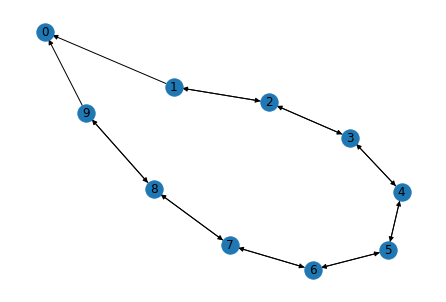

In [24]:
G = nx.cycle_graph(10)
G = nx.Graph.to_directed(G)
G.remove_edges_from([(0,1),(0,9)])
G.add_edge(0,0)

nx.draw(G, with_labels=True)

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# start with random initial states and run the dynamics
alfa_err = np.zeros(200)

for i in range(200):
# rand returns random values in [0,1], thus \mu = 1/2
    x = np.random.rand(10)
    var = np.var(x)
    for n in range(500):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))

print("Expected variance of the node states:", 1/12)
print("Empirical variance of the consensus state:", np.mean(alfa_err), "\n")

In this graph the consensus value is exactly the initial state of node $0$, because the condensantion graph has 1 sink only, which is node $0$.

$$
\pi = \delta^{(0)}.
$$

This graph is the opposite of the complete graph, in the sense that all the invariant distribution centrality is totally on node $0$. Thus the variance of the consensus state equals the variance of the single node.

Note that this argument holds independently of the size of the graph.

### <span style="background-color: #00FF00">Application: distributed computation of average</span>

Let the node set describe a set of sensors that are deployed in some region in order to collect measurements of some quantity of interest (for example, the temperature). 

Assume that these sensors have limited communication and computation capabilities that allow each of them to exchange information only with those other sensors that are close enough in space. 

Let the graph $G = (V, E)$ describe the pattern of closeness among the sensors $i$ and $j$ so that there is an undirected link between node $i$ and node $j$ if they can communicate to each other (possibly using link weights decreasing with distance). Then, one can design a distributed algorithm for computing the average of the sensor's measurements based on the averaging dynamics.

Let $x_i(0)$ be the measurement of each node. 

We are interested in designing an iterative distributed algorithm that allows the nodes to compute

$$
x = \frac{1}{n}\sum_i x_i(0)
$$

**First attempt**: we run a consensus algorithm. Since the graph is undirected, $\pi_i = \frac{w_i}{\sum_j w_j}$. Thus, the algorithm converges to a consensus $\alpha \mathbf{1}$ such that

$$
\alpha = \sum_{i} \frac{w_i}{w} x_i(0).
$$

If each edge knows its degree $w_i$, each node can rescale its initial state, i.e., $y_i(0) = \frac{x_i(0)}{w_i}$. The consensus algorithm for the variable $y_i$ thus converges to

$$
\alpha_y = \sum_{i} \frac{w_i}{w} y_i(0) = \frac{1}{w} \sum_{i} x_i(0).
$$

If we assume that each node knows the average degree of the network, thus

$$
x = \alpha_y \frac{w}{n} = \alpha_y \overline{w}.
$$


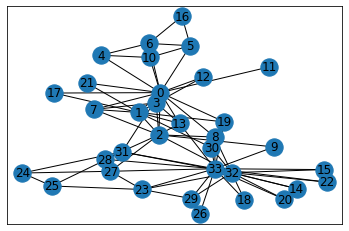

In [25]:
G = nx.karate_club_graph()

# Fix node positions on all pictures according to spring layout
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos)

n_nodes = len(G)

x = np.random.rand(n_nodes)

In [26]:
# Let us run the consensus algorithm for y

# Construct P
W = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
W = W.toarray() # convert A to a numpy array
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

y = x/degrees

for t in range(1000):
    y = P @ y

print("average state:", np.mean(x))
# choose arbitrarly the first node, but all the nodes reach consensus on y
print("average computed distributively", y[0] * np.sum(degrees) / n_nodes)

average state: 0.5376043060162634
average computed distributively 0.5376043060162619


The algorithm works! Unfortunately, requiring that each node knows the average degree of the network is not realistic and is not distributed, because it requires that each node has some global information on the network.

However, there exists another way to solve the problem.

**Second attempt**: we run a second averaging dynamics, with initial condition $z_i(0) = \frac{1}{w_i}$.

This converges to

$$
\alpha_z = \lim_{t \to + \infty} z_i(t) = \sum_i z_i(0) \frac{w_i}{w} = \sum_{i} \frac{1}{w} = \frac{1}{\overline{w}}
$$

By combining the two, each node can estimate the average estimate by 

$$
\frac{\lim_{t \to + \infty} y_i(t)}{\lim_{t \to + \infty} z_i(t)} = \frac{\alpha_y}{\alpha_z} = \frac{x}{\overline{w}} \cdot \overline{w} = x.
$$

This method does not require any global knowledge on the network and it is distributed.

In [27]:
# Let us implement this

z = 1/degrees

for t in range(1000):
    z = P @ z

print("average state:", np.mean(x))
# choose arbitrarly the first node, but all the nodes reach consensus both on y and z
print("average computed distributively", y[0] / z[0])

average state: 0.5376043060162634
average computed distributively 0.5376043060162633
